# Captioning


To accomplish the goal of this project, we decided to use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption. The general structure of the model that we are creating is shown in the picture below. 


**Main components of the model**

- **Tokenizer:** is the vocabulary element of this model as it receives the entire stream of characters included in the real captions generated by Medical experts and breaks it up into individual words it calls tokens, splitting them every time it sees a white space.
- **CNNs (Convolutional Neural Networks):** are Deep Learning algorithms that can take in an input image, assign importance (learnable weights and biases) to various aspects/objects in the image and be able to differentiate one from the other.

- **RNNs (Recurrent Neural Networks):** are Deep Learning algorithms where connections between nodes form a directed or undirected graph along a temporal sequence.

![Picture title](image-20211217-202005.png)

In [2]:
import tensorflow as tf
from IPython.display import Image
from IPython.core.display import HTML 

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt
from tqdm import tqdm
# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
# import tensorflow as tf
import xml.etree.ElementTree
import numpy as np
import pandas as pd
import re
import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle
from keras.layers import Activation, Dense


In [3]:
print(tf.__version__)

2.6.0


In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

### Download and prepare the dataset

In [25]:
frontal_train = pd.read_pickle("../data/train/frontal_train.pickle").reset_index(drop=True)

image_folder = "/datasets/gdrive/XRay-AKAKI/images_normalized/"

frontal_test = pd.read_pickle('../data/test/frontal_test.pickle').reset_index(drop=True)
#test_descs = frontal_test['caption']

#Randomly select 20 x-ray images for train and 20 for testing
train = frontal_train

train_path = train['filename']

train_descs = train['findings']


In [26]:
## https://github.com/wisdal/diagnose-and-explain/blob/master/prepare_dataset.py

img_names = train_path.to_numpy()
numpy_standholder = [image_folder] * len(img_names)
all_img_names = numpy_standholder + img_names
impressions = train['impression'].to_numpy()

start_standholder = ['<start> '] * len(impressions)
end_standholder = [' <end>' ] * len(impressions)
all_impressions = start_standholder + impressions + end_standholder
all_findings = train['findings'].to_numpy()

print(all_img_names)

['/datasets/gdrive/XRay-AKAKI/images_normalized/2_IM-0652-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3_IM-1384-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/4_IM-2050-1001.dcm.png'
 ...
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3995_IM-2046-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3996_IM-2047-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3999_IM-2049-1001.dcm.png']


### Preprocess the images using InceptionV3

We will use InceptionV3 (which is pretrained on Imagenet) to extract features from the images

In [28]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (512, 624))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [30]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                          weights = 'imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [31]:
print(all_img_names)

['/datasets/gdrive/XRay-AKAKI/images_normalized/2_IM-0652-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3_IM-1384-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/4_IM-2050-1001.dcm.png'
 ...
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3995_IM-2046-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3996_IM-2047-1001.dcm.png'
 '/datasets/gdrive/XRay-AKAKI/images_normalized/3999_IM-2049-1001.dcm.png']


In [32]:
# Get unique images
# all_findings, all_impressions, all_img_names, report_id

encode_train = sorted(set(all_img_names))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
print(image_dataset)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

<TensorSliceDataset shapes: (), types: tf.string>


In [33]:
from tensorflow.keras.preprocessing.image import load_img

image = load_img(image_folder + '1349_IM-0227-1001.dcm.png')

print(image_dataset)

<BatchDataset shapes: ((None, 512, 624, 3), (None,)), types: (tf.float32, tf.string)>


In [34]:
for img, path in tqdm(image_dataset):
  #print(img)
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

100%|██████████| 45/45 [1:39:36<00:00, 132.82s/it]


### Tokenize the captions

In the following cells of code will transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

- Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top 5,000 words (to save memory).
- Tokenize all captions by mapping each word to it's index in the vocabulary. All output sequences will be padded to length 50.
- Create word-to-index and index-to-word mappings to display results.

In [35]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = top_k,
                                                  oov_token="<unk>",split=' ', char_level=False,
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(all_impressions)
train_seqs = tokenizer.texts_to_sequences(all_impressions)
# tokenizer.fit_on_texts(df['impressions'])
# train_seqs = tokenizer.texts_to_sequences(df['impressions'])
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [36]:
import pickle

#saving Tokenizer object
# Stackoverflow "Keras Text Processing - Saving Tokenizer object to file for scoring"

with open('tokenizer.pkl', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol = pickle.HIGHEST_PROTOCOL)


In [39]:
# Create the tokenized vectors
# train_seqs = tokenizer.texts_to_sequences(all_impressions)
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)
max_length

In [41]:
# Create training and validation sets using an 80-20 split
img_name_train, img_name_val, cap_train, cap_val = train_test_split(all_img_names,
                                                                    cap_vector,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [42]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(2276, 2276, 569, 569)

In [43]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 8
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [44]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [45]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

### The Model

The model architecture is inspired by the Show, Attend and Tell paper.
- It uses InceptionV3 to extract features from the images 
- The vector is then passed through the CNN Encoder
- The RNN goes the attends over the image to predict the next word

In [46]:
## https://www.tensorflow.org/tutorials/text/image_captioning
## Code taken from official Tensorflow website

#import torch
#import torch.nn as nn
#import torchvision.models as models

class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class AttentionVisual(tf.keras.Model):
  def __init__(self, vis_enc_dim, sent_hidden_dim, att_dim):
    super(AttentionVisual, self).__init__()

    # self.enc_att = nn.Linear(vis_enc_dim, att_dim)
    self.enc_att = tf.keras.layers.Dense(att_dim, activation = 'linear') # input_shape=vis_enc_dim
    # self.dec_att = nn.Linear(sent_hidden_dim, att_dim)
    self.dec_att = tf.keras.layers.Dense(att_dim, activation = 'linear') # input_shape = sent_hidden_dim,
    # self.tanh = nn.Tanh()
    self.tanh = tf.keras.layers.Activation('tanh')
    # self.full_att = nn.Linear(att_dim, 1)
    self.full_att = tf.keras.layers.Dense(1, activation = 'linear') # input_shape = att_dim,
    # self.softmax = nn.Softmax(dim = 1)
    # self.softmax = tf.nn.softmax(axis = 1)

  def call(self, vis_enc_output, dec_hidden_state):
    # vis_enc_output = visual
    # dec_hidden_state = hidden

    vis_enc_att = self.enc_att(vis_enc_output)	# (batch_size, num_pixels, att_dim)

    dec_output = self.dec_att(dec_hidden_state) # (batch_size, att_dim)

    join_output = self.tanh(vis_enc_att + tf.expand_dims(dec_output, 1)) # (batch_size, num_pixels, att_dim)

    join_output = tf.squeeze(self.full_att(join_output)) # (batch_size, num_pixels)

    att_scores = tf.nn.softmax(join_output, axis = 1) # (batch_size, num_pixels)

    #att_output = torch.sum(att_scores.unsqueeze(2) * vis_enc_output, dim = 1)
    att_output = tf.reduce_sum(tf.expand_dims(att_scores, 2)*vis_enc_output, axis = 1)

    return att_output, att_scores


class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it using pickle
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    
    self.W1 = tf.keras.layers.Dense(units)
    
    self.W2 = tf.keras.layers.Dense(units)
    
    self.V = tf.keras.layers.Dense(1)
    
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc1 = tf.keras.layers.Dense(self.units)
    
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    #context_vector, attention_weights = self.attention(features, hidden)

    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (batch_size, 64, hidden_size)
    score = tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis))

    # attention_weights shape == (batch_size, 64, 1)
    # you get 1 at the last axis because you are applying score to self.V
    attention_weights = tf.nn.softmax(self.V(score), axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    
    context_vector = tf.reduce_sum(context_vector, axis=1)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


class RNN_DecoderVA(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_DecoderVA, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = AttentionVisual(embedding_dim, self.units, vocab_size)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))



In [47]:
encoder = CNN_Encoder(embedding_dim)
# decoder = RNN_Decoder(embedding_dim, units, vocab_size)
decoder_va = RNN_Decoder(embedding_dim, units, vocab_size)

In [49]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [50]:
checkpoint_path = "/content/checkpoints"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder_va,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [51]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

In [52]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [53]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder_va.reset_state(batch_size=target.shape[0])
  #print("Printing hidden", hidden)

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          #print(i)
          # passing the features through the decoder
          predictions, hidden, _ = decoder_va(dec_input, features, hidden)
          #print("Printing predictions", predictions) 
          #print("Printing hidden", hidden)

          loss += loss_function(target[:, i], predictions)
          #print("Printing loss", loss)
          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)
          #print("Printing dec_input: ", dec_input)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder_va.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [54]:
EPOCHS = 30
# with strategy.scope():
for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            print ('Epoch {} Batch {} Loss {:.4f}'.format(
              epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    # if you want to checkpoint
    # if epoch % 5 == 0:
    #   ckpt_manager.save()

    print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

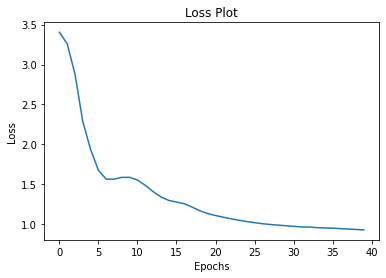

In [ ]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [73]:
import PIL.Image

def plot_attention(image, result, attention_plot):
    # img_name_to_save=image
    temp_image = np.array(PIL.Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2 +1, len_result//2 + 1, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    #plt.savefig("figure_latest.png") # save as png
    plt.show()

In [62]:
#max_length = 114

def evaluate(image):
    # attention_plot = np.zeros((max_length, attention_features_shape))
    attention_plot = np.zeros((max_length, 252))
    # print('attention plot shape ',attention_plot.shape)
    hidden = decoder_va.reset_state(batch_size=1) 
    # print("hidden shape", hidden.shape)
    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    # print("temp input shape", temp_input.shape)
    img_tensor_val = image_features_extract_model(temp_input)
    # print("img tensor val shape", img_tensor_val.shape)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    # print("img tensor val shape after reshape", img_tensor_val.shape)
    # print(img_tensor_val)
    features = encoder(img_tensor_val)
    # print(features)
    # print("Encoder output features shape ", features.shape)
    # dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    # print('shape dec input ', dec_input.shape)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder_va(dec_input, features, hidden)
        
        #decoder_va(dec_input, features, hidden).save('/content/decoderRNN', save_format = 'tf')


        # print('attention weights shape ',attention_weights.shape)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
        

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

### Making  Predictions on the test dataset

Using the functions above we make predictions on the testing images; furthermore, we provide both the real and predicted caption, so it is easier to evaluate "the accuracy" of the model. 

Real Caption: <start> no acute cardiopulmonary abnormality <end>
Prediction Caption: no acute cardiopulmonary abnormality <end>


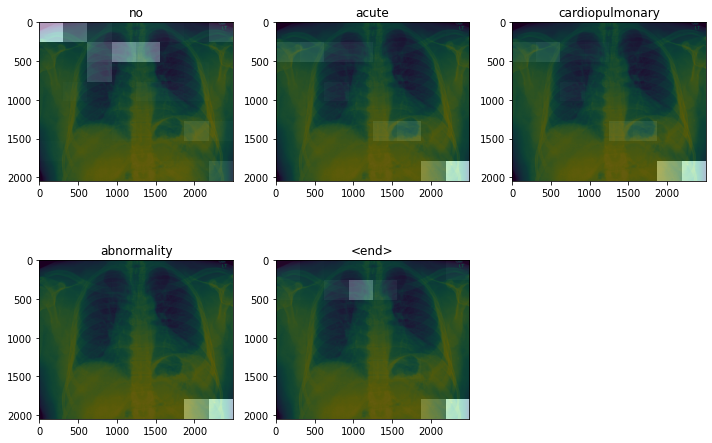

In [83]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> clear lungs no acute chest findings peripheral vascular disease <end>
Prediction Caption: increased lower cervical this has been aspiration evaluate this may be useful <end>


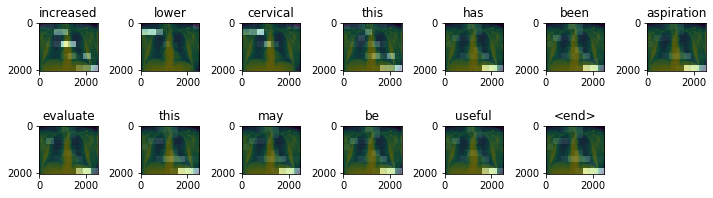

In [89]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> no acute pulmonary disease <end>
Prediction Caption: negative chest radiograph stable bullous abnormality widening on midlung and along the chest <end>


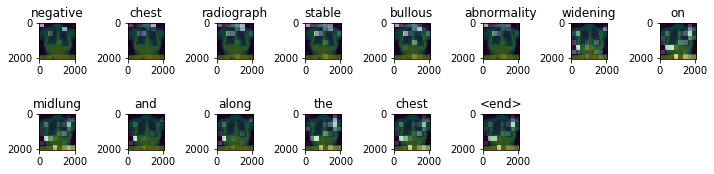

In [64]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: <start> no acute cardiopulmonary abnormality identified <end>
Prediction Caption: no focal airspace disease measuring approximately demonstration of an goiter <end>


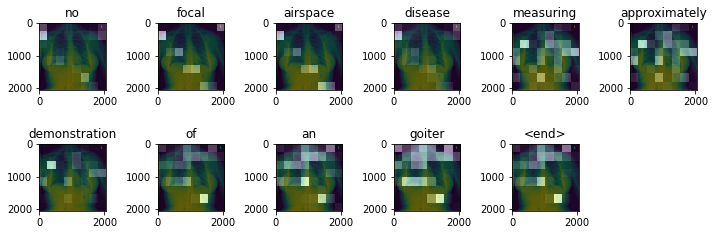

In [80]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> no acute pulmonary disease <end>
Prediction Caption: unremarkable chest contrastenhanced radiograph seen the right base is not not available consideration curvature of the mid thoracic vertebral aorta there are compared to notification documented through primordial <end>
/shared-libs/python3.6/py-core/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


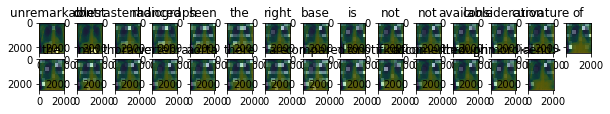

In [85]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

# plt.savefig('sample.pdf')

Real Caption: <start> no acute cardiopulmonary findings <end>
Prediction Caption: no acute cardiopulmonary disease <end>


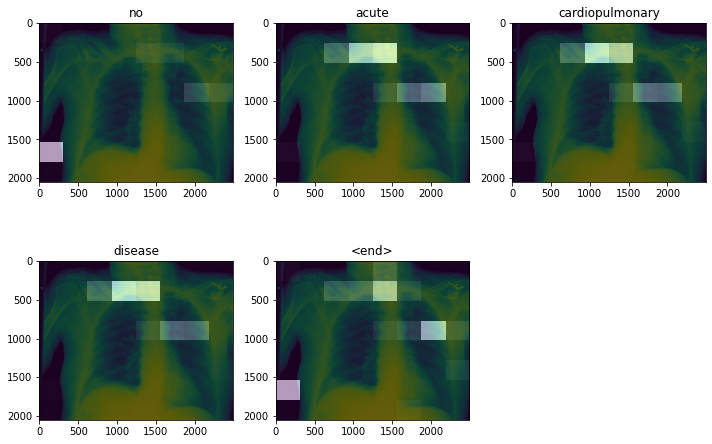

In [90]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)


Real Caption: <start> no evidence of acute cardiopulmonary process stable appearance of the chest <end>
Prediction Caption: mild cardiomegaly <end>


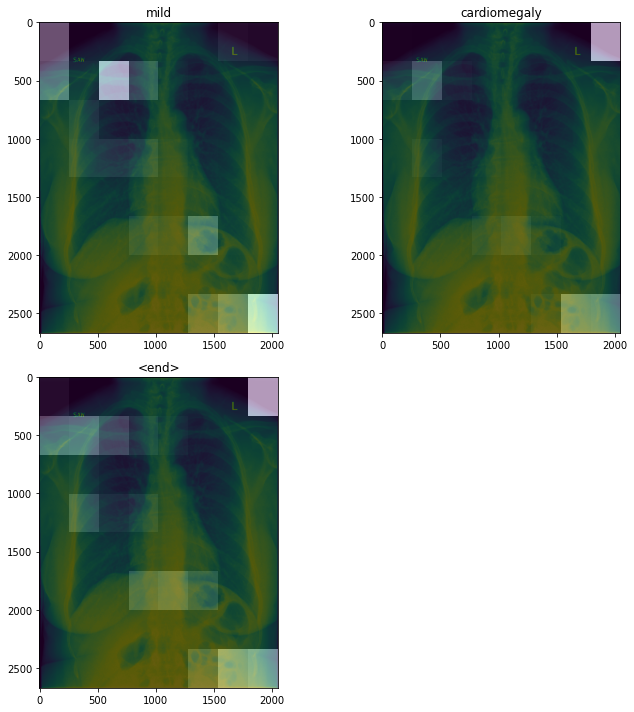

In [92]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> low lung volumes mild crowding <end>
Prediction Caption: cardiomegaly chest stable mild aspect of inflammatory aspiration <end>


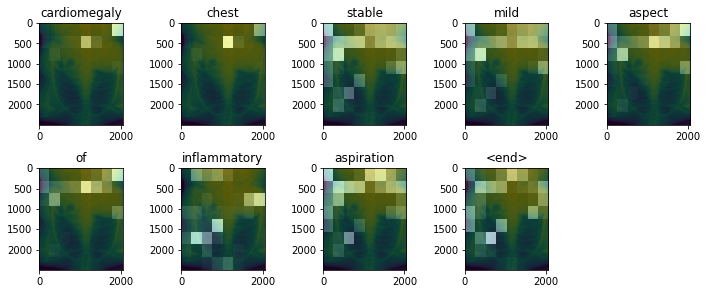

In [100]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> retained contrast in the distal esophagus unchanged right hilar mass <end>
Prediction Caption: bilateral heart size is normal findings of now displaced rib histoplasmosis limits of acute process <end>


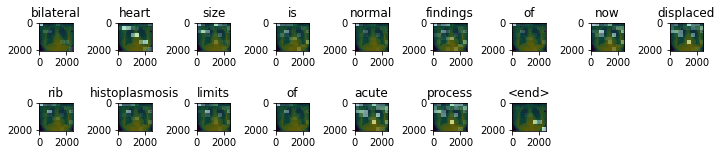

In [74]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

Real Caption: <start> no acute cardiopulmonary abnormality <end>
Prediction Caption: no acute preoperative findings <end>


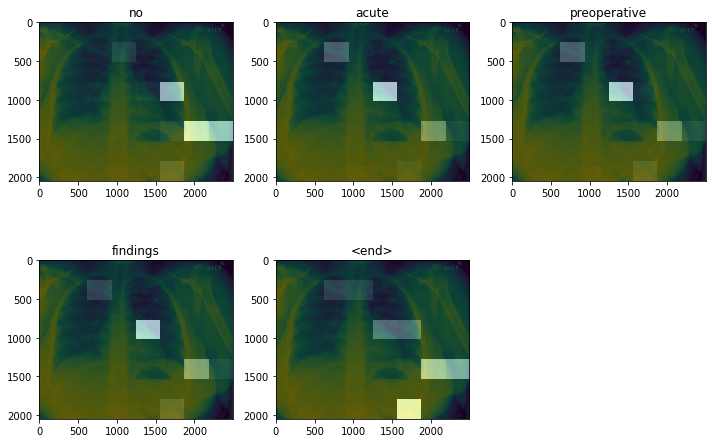

In [102]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))   #from live session code on URL Shortner
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print ('Real Caption:', real_caption)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

In [26]:
store = tokenizer.index_word
def calculateOutputs(img_name_val, store, n):
    predicted_captions = []
    real_captions = []
    random_ids = range(0, n)
    for i in random_ids:
        real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
        image = img_name_val[i]
        predicted_caption, _ = evaluate(image)
        predicted_captions.append(predicted_caption)
        real_captions.append(real_caption)

    return predicted_captions, real_captions

#predicted_captions, real_captions = calculateOutputs(img_name_val, tokenizer.index_word, n=100)

predicted_caption_0 = ['no', 'acute', 'preoperative' ,'findings', '<end>']
real_caption_0 = ['<start>', 'no', 'acute', 'cardiopulmonary' ,'abnormality' ,'<end>']

real_caption_1 = ['<start>', 'retained', 'contrast','in' ,'the' ,'distal' ,'esophagus' ,'unchanged' ,'right' ,'hilar' ,'mass', '<end>']
predicted_caption_1 = ['bilateral' ,'heart' ,'size' ,'is' ,'normal' ,'findings' ,'of' ,'now' ,'displaced' ,'rib' ,'histoplasmosis' ,'limits' ,'of' ,'acute' ,'process' ,'<end>']


### Computing Bleu Score

In [27]:
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

pred_caption0 = " ".join(predicted_caption_0)
pred_caption1 = " ".join(predicted_caption_1)
real_caption0 = " ".join(real_caption_0)
real_caption1 = " ".join(real_caption_1)

predicted_captions = [pred_caption0, pred_caption1]
real_captions = [real_caption0, real_caption1]

def calculate_bleu_evaluation(predicted_captions, real_captions):
    scores = []
    for i in range(len(predicted_captions)):
        score = sentence_bleu(real_captions[i], predicted_captions[i])
        scores.append(score)
    return scores, np.mean(scores)

calculate_bleu_evaluation(predicted_captions, real_captions)

/shared-libs/python3.6/py/lib/python3.6/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/shared-libs/python3.6/py/lib/python3.6/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/shared-libs/python3.6/py/lib/python3.6/site-packages/nltk/translate/bleu_score.py:515: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or

([1.4637115948630222e-231, 1.188226951936415e-231], 1.3259692733997187e-231)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=d67d5ca8-f99a-4baf-8748-4aa99efbd09b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>